<font size='6'><b><center>Appendix A</center></b></font>
<font size='6'><b><center>Scipy Optimize Theoretical Toy Model</center></b></font>

The following two cells enable automatic equation numbering for this document using <a href="https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/equation-numbering/readme.html">MathJax</a>.

In [3]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [4]:
%%javascript
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [3]:
fig_num = 1

# Fundamental problem

Observing a galaxy's line luminosity with a single-dish telescope, we can represent this value as a weighted sum over several molecular clouds. If we say these clouds fall into $m$ cloud categories and we are observing $n$ molecular emission lines, the ($m\times{}n$)-dimensional cloud luminosity can be represented by $\hat{L}_{\text{cloud}}$ and the $n$-dimensional galaxy luminosity can be represented as $\vec{L}_{\text{gal}}$. Thus, the galaxy's line luminosity in emission line $j$ can be expressed as

\begin{equation}
{L}_{\text{gal},\,j} = 
    {L}_{\text{a},\,j} \cdot w_\text{a}+
    \ldots+
    {L}_{m,\,j} \cdot w_m \quad ,
\end{equation}

or as

\begin{align}
\vec{L}_{\text{gal}} &= 
    \sum_{i}^m \vec{L}_i \cdot w_i \\
    & = \hat{L}_{\text{cloud}} \cdot \vec{w} \quad , 
    \label{eq:main_eq}
\end{align}

where $\vec{w}$ is an $m$-dimensional vector representing the weight for each molecular cloud category. Thus, our question is *if the galaxy luminosity $\vec{L}_{\mathrm{gal}}$ and molecular cloud luminosity $\hat{L}_{\text{cloud}}$ are known, can we determine the weight $w_i$ that each cloud category has on the combined signal?*

In theory, this problem is a high-dimensional system of linear equations, where there are $n$ constraints and $m$ unknowns. So, it's reasonable to assume the weight coefficients $\vec{w}$ can be accurately predicted only when the system has fewer constraints than unknowns.

Here, we approach this question as a theoretical optimization problem, where we minimize the difference between a galaxy model $\vec{L}_{\mathrm{model}}$ and our synthetic observations $\vec{L}_{\mathrm{gal}}$. In other words, the "distance" between both vectors is minimized to predict weights $\vec{w}$ which produce our observations. This distance can be expressed as

\begin{equation}
{F_{\vec{L}}=(\vec{L}_{\mathrm{gal}}-\vec{L}_{\mathrm{model}})^2} \quad . \label{eq:dist_eq}
\end{equation}

# Setting up the model

The minimization is performed using the `scipy.optimize.minimize` function. In some cases, a penalty term is desirable to ensure the minimization accurately represents system we are modeling. In this document, we implemented a penalty term $g(\vec{w})$ to satisfy $w_i \geq 0$ since negative weights can not physically exist in our system. The penalty term  ${g(\vec{w})}$  can be added as

\begin{equation}
{F_{\vec{L}}*  = F_{\vec{L}} + g(\vec{w})} \quad ,
\\ {\text{ where } g(\vec{w})= 
\begin{cases} 
0 & w_i \geq 0 \\ \infty & w_i < 0 
\end{cases}} \quad . \label{eq:penalty_eq}
\end{equation}

To analyze the accuracy of the weights outputted by our optimization, we calculate the percent error between the observed weight vector $\vec{w}_{\mathrm{obs}}$ and model weight vector $\vec{w}_{\mathrm{model}}$ as a vector $\vec{w}_\mathrm{err}$, where

\begin{equation}
w_{\mathrm{err},\ i} = {{|w_{\mathrm{model},\ i}-w_{\mathrm{obs},\ i}|} \over {w_{\mathrm{obs},\ i}}} \quad . \label{eq:error_eq}
\end{equation}

An evaluation metric (e.g. mean, median, or maximum) is applied to $\vec{w}_\mathrm{err}$, resulting in a single representative error value.

This document utilizes <a href="https://numpy.org/doc/stable/"> NumPy</a>, <a href="https://docs.scipy.org/doc/scipy/"> SciPy</a>, <a href="https://docs.astropy.org/en/stable/index.html"> Astropy</a>, <a href="https://matplotlib.org/stable/index.html"> Matplotlib</a>, and <a href="https://tqdm.github.io/docs/tqdm/"> tqdm</a> libraries.

In [4]:
import numpy as np
import scipy.optimize as opt
from scipy.optimize import Bounds
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import warnings # removing warnings
warnings.filterwarnings('ignore')

# plotting specifications
from cycler import cycler
plt.rc('axes',prop_cycle=(cycler('color', ['k','b','g','r','c','m','y'])))
plt.rcParams['text.usetex']= True
plt.rcParams['mathtext.fontset']= 'custom'
plt.rcParams['mathtext.default']= 'rm'
plt.rcParams['axes.formatter.use_mathtext']=False
#----------------------------------------
plt.rcParams['font.size']= 15.0
plt.rcParams['axes.labelsize']= 16.0
plt.rcParams['axes.unicode_minus']= False
plt.rcParams['xtick.major.size']= 6
plt.rcParams['xtick.minor.size']= 3
plt.rcParams['xtick.major.width']= 1.5
plt.rcParams['xtick.minor.width']= 1.0
plt.rcParams['axes.titlesize']= 20 
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize']= 20 
plt.rcParams['ytick.major.width']= 2.0 
plt.rcParams['ytick.minor.width']= 1.0 

%matplotlib inline

First, we define the function we intend to minimize (Eq. $\ref{eq:dist_eq}$). An optional `penalty` term from Eq. $\ref{eq:penalty_eq}$ can be passed through this function.

In [5]:
def dist_func(weights, m, gal_obs, cloud_obs, penalty):
    '''
    SUMMARY:
    Computes the Euclidean distance between observed and model galaxy luminosity vectors

    PARAMETERS:
    weights (arr): m-dimensional weight vector
    m (int): number of molecular clouds
    g_luminosity (arr): n-dimensional galaxy luminosity vector
    luminosities (arr): (m x n)-dimensional molecular cloud luminosity vector
    penalty (bool): determines whether penalty variable is used for constraint
    '''
    # ---- penalty term ----
    g = 0
    if penalty:
        for i in range(m):
            if weights[i] < 0:
                g = np.inf
    # -------------------------
    lModel = np.dot(weights,cloud_obs)
    dist = np.linalg.norm(gal_obs - lModel)**2
    return dist + g

Next, we define a function which generates our synthetic observations satisfying Eq. $\ref{eq:main_eq}$ and performs the minimization. Synthetic observations ${w}_{i}$ and ${L}_{i,\,j}$ are sampled from random instances within [0,1], which produce ${L}_{\mathrm{gal},\,j}$. Measurement uncertainties $\delta {L}_{i,\,j}$ and $\delta {L}_{\mathrm{gal},\,j}$ are sampled from random instances of a normal distribution with a standard deviation of 0.1, corrupting ${L}_{i,\,j}$ and ${L}_{\mathrm{gal},\,j}$. These corruptions are added as

\begin{equation}
{\hat{L}_{\mathrm{cloud,\ obs}} = \hat{L}_{\mathrm{cloud}} + \delta \hat{L}_{\mathrm{cloud}}} \quad , \label{eq:likelihood_one_eq}
\end{equation}

\begin{equation}
{\vec{L}_{\mathrm{gal,\ obs}} = \vec{L}_{\mathrm{gal}} + \delta \vec{L}_{\mathrm{gal}}} \quad . \label{eq:likelihood_two_eq}
\end{equation}

These synthetic observations are not necessarily realistic, as luminosity signals normally vary within a broader range of values than [0,1]. In this work, we use small values to serve as a toy model approach to the theoretical problem. 

We then pass $\vec{L}_{\mathrm{gal,\ obs}}$ and $\hat{L}_{\mathrm{cloud,\ obs}}$ on a routine that predicts $\vec{w}$ through the minimization of Eq. $\ref{eq:dist_eq}$. There is an optional `bounds_constraint` term passed through this minimization function. This is an alternative way of applying a penalty, where bounds on $\vec{w}_{\mathrm{model}}$ are applied directly within the `scipy.optimize.minimize` function.

In [6]:
def minimize(m, n, solver, bounds_constraint, penalty):
    '''
    SUMMARY:
    Generates synthetic observation
    Determines corresponding weights for this observation

    PARAMETERS:
    m (int): number of molecular clouds
    n (int): number of emission lines
    solver (str): type of SciPy minimize solver
    bounds_constraint (bool): determines whether bounds are used for constraint
    penalty (bool): determines whether penalty variable is used for constraint
    '''
    # true values
    cloud_luminosity = np.random.rand(m,n)
    weights = np.random.rand(m)
    gal_luminosity = np.dot(weights, cloud_luminosity)
    # known uncertainty
    cloud_err = np.random.normal(0, 0.1, size=(m,n))
    gal_err = np.random.normal(0, 0.1, size=(n))
    # observations
    cloud_obs = np.add(cloud_luminosity, cloud_err)
    gal_obs = np.add(gal_luminosity, gal_err)

    if bounds_constraint:
        # applying constraint to weights
        ub = np.full(m, 1)
        lb = np.full(m, 0)
        bnds = Bounds([lb],[ub])
        # minimization
        result = opt.minimize(dist_func,
                              x0=np.full(m, 0.5),
                              args=(m, gal_obs, cloud_obs, penalty),
                              method = solver,
                              bounds=bnds)
    else:
        # minimization
        result = opt.minimize(dist_func,
                              x0=np.full(m, 0.5),
                              args=(m, gal_obs, cloud_obs, penalty),
                              method = solver)
    return {"input_luminosities": cloud_luminosity,
            "input_weights": weights,
            "galaxy_luminosity": gal_luminosity,
            "output_weights": result.x,
            "F(l)": result.fun}

To calculate how far off $\vec{w}_{\mathrm{model}}$ is from $\vec{w}_{\mathrm{obs}}$, we define the following function. An evaluation metric term `eval_metric` is applied to the error vector $\vec{w}_\mathrm{err}$ outputted by Eq. $\ref{eq:error_eq}$, resulting in a single representative error value.

In [7]:
def getPercentError(original, test, eval_metric):
    '''
    SUMMARY:
    Applies specified percent error metric to weights

    PARAMETERS:
    original (arr): initial weight vector
    test (arr): new weight vector
    eval_metric (str): specified statistical metric
    '''
    absolute = np.absolute(np.subtract(test, original))
    divided_absolute = np.divide(absolute, original) * 100

    if eval_metric == "mean":
        averaged_divided_absolute = np.average(divided_absolute)
    elif eval_metric == "max":
        averaged_divided_absolute = np.amax(divided_absolute)
    elif eval_metric == "median":
        averaged_divided_absolute = np.median(divided_absolute)
    return averaged_divided_absolute

Then, we define a function which runs a single instance of $m$ and $n$ through `minimize` iteratively. The `iterate` term determines the number of times the experiment is performed. Averaging over several iterations of the experiment, we reduce the chances of outlier results. In other words, a higher `iterate` term gives a more accurate representation of error in the model.

The output `summarized_data` is given as a table of a single row containing the inputted $m$ and $n$ values, the average minimized distance calculated in Eq. $\ref{eq:dist_eq}$, and the average of various characterizations of the model weight error $\vec{w}_\mathrm{err}$. The `solver` term specifies the type of minimization method used. There are numerous <a href="https://scipy-lectures.org/advanced/mathematical_optimization/#choosing-a-method">SciPy Optimize Minimize solvers</a>, some of which support constrainted optimization (e.g. COBYLA and SLSQP).

In [8]:
def run_single(m, n, iterate, solver, bounds_constraint, penalty, filename):
    '''
    SUMMARY:
    Calls minimize function for a single experiment
    Creates table and .ecsv file of data run

    PARAMETERS:
    m (int): number of molecular clouds
    n (int): number of emission lines
    iterate (int): # of iterations
    solver (str): type of SciPy minimize solver
    bounds_constraint (bool): determines whether bounds are used for constraint
    penalty (bool): determines whether penalty variable is used for constraint
    filename (str): .ecsv filename
    '''
    time_start = time.time()
    
    # initializing table and lists
    summarized_data = Table([])
    min_dist = []
    mean_error = []
    median_error = []
    
    for k in range(iterate):
        result = minimize(m, n, solver, bounds_constraint, penalty)
        # appending each iteration to existing lists
        min_dist.append(result["F(l)"])
        mean_error.append(getPercentError(result["input_weights"], 
                                          result["output_weights"], 
                                          "mean")
                         )
        median_error.append(getPercentError(result["input_weights"], 
                                            result["output_weights"], 
                                            "median")
                           )
    # saving lists to table
    summarized_data['m'] = [m]
    summarized_data['n'] = [n]
    summarized_data['F(l)'] = [np.average(min_dist)]
    summarized_data['Percent Error Mean'] = [np.average(mean_error)]
    summarized_data['Percent Error Median'] = [np.average(median_error)]
    
    # saving and retrieving run in *.ecsv* file
    summarized_data.write(f"{filename}.ecsv", overwrite=True)
    summarized_data = Table.read(f"{filename}.ecsv")
    print('\nTime elapsed: {} seconds'\
          .format(round((time.time() - time_start),2)))
    return summarized_data

In a similar manner, we define a function which runs multiple instances of $m$ and $n$ through `minimize` iteratively, giving us the ability to test multiple experiements simultaneously. The `m_n_array` term is a specified array of $m$ and $n$ values. The function iteratively runs every possible combination of numerical pairs in `m_n_array` through `minimize`. 

The output term `summarized_data` is given as a table, where each row contains the inputted $m$ and $n$ value, the average minimized distance calculated in Eq. $\ref{eq:dist_eq}$, and the average of various characterizations of the model weight error $\vec{w}_\mathrm{err}$. Another output term `data` contains the unaveraged data, where each row contains information for each iteration.

In [9]:
def run_multiple(m_n_array, iterate, solver, bounds_constraint, penalty, filename):
    '''
    SUMMARY:
    Calls minimize function for multiple experiments
    Creates table and .ecsv file of data run

    PARAMETERS:
    m_n_array (arr): m and n values
    iterate (int): # of iterations
    solver (str): type of SciPy minimize solver
    bounds_constraint (bool): determines whether bounds are used for constraint
    penalty (bool): determines whether penalty variable is used for constraint
    filename (str): .ecsv filename
    '''
    data = Table([])
    time_start = time.time()
    pbar = tqdm(desc="Progress", total = len(m_n_array)**2*iterate)
    tqdm._instances.clear()
    
    # running iterations for each unique m and n combination
    for num_molecular_clouds in m_n_array:
        for num_line in m_n_array:
            for k in range(iterate):
                result = minimize(num_molecular_clouds, 
                                  num_line, 
                                  solver, 
                                  bounds_constraint, 
                                  penalty
                                 )
                experiment_data = Table([])
                experiment_data["m"] = [num_molecular_clouds]
                experiment_data["n"] = [num_line]
                experiment_data["input_luminosities"] = \
                    [np.array(str({"data": np.array(result["input_luminosities"])}), dtype=str)]
                experiment_data["input_weights"] = \
                    [np.array(str({"data": np.array(result["input_weights"])}), dtype=str)]
                experiment_data["output_weights"] = \
                    [np.array(str({"data": np.array(result["output_weights"])}), dtype=str)]
                experiment_data["F(l)"] = [result["F(l)"]]
                experiment_data["Percent Error Mean"] = \
                    [getPercentError(result["input_weights"], result["output_weights"], "mean")]
                experiment_data["Percent Error Median"] = \
                    [getPercentError(result["input_weights"], result["output_weights"], "median")]
                experiment_data["Percent Error Max"] = \
                    [getPercentError(result["input_weights"], result["output_weights"], "max")]
                data = vstack([data, experiment_data])
                pbar.update(1)

    # averaging over iterations
    summarized_data = Table([])
    for i in range(0, len(data), iterate):
        row = Table([])
        row["m"] = [data["m"][i]]
        row["n"] = [data["n"][i]]
        row["F(l)"] = \
            [np.average(data["F(l)"][i:i+iterate].data)]
        row["Percent Error Mean"] = \
            [np.average(data["Percent Error Mean"][i:i+iterate].data)]
        row["Percent Error Median"] = \
            [np.average(data["Percent Error Median"][i:i+iterate].data)]
        row["Percent Error Max"] = \
            [np.average(data["Percent Error Max"][i:i+iterate].data)]
        summarized_data = vstack([summarized_data, row])

    # saving and retrieving run in *.ecsv* file
    summarized_data.write(f"{filename}.ecsv", overwrite=True)
    summarized_data = Table.read(f"{filename}.ecsv")
    print('\nTime elapsed: {} seconds'\
          .format(round((time.time() - time_start),2)))
    return summarized_data, data

Lastly, a plotting function is defined using `pcolormesh` to visualize the output of `run_multiple` in one figure. Each data point in the plot contains a row within `summarized_data`. In other words, each "pixel" represents an experiment performed with a given $m$ and $n$ value, averaged over a given amount of iterations.

In [10]:
def plot_colormesh(m_n_array, summarized_data, evaluation_metric, fig_num, description):
    '''
    SUMMARY:
    Creates a colormesh plot of data run

    PARAMETERS:
    m_n_array (arr): m and n values
    summarized_data (astropy.table): table containing data run
    evaluation_metric (str): specified statistical metric
    fig_num (str): running figure number
    description (str): displayed figure description
    '''
    plt.style.use('_mpl-gallery-nogrid')
    fig, ax = plt.subplots(figsize=(4,4))

    input_length = len(m_n_array)
    graph = ax.pcolormesh(np.array(np.reshape(summarized_data["n"], 
                                              [input_length, input_length]
                                             )),
                          np.array(np.reshape(summarized_data["m"], 
                                              [input_length, input_length]
                                             )),
                          np.array(np.reshape(summarized_data[evaluation_metric], 
                                              [input_length, input_length]
                                             )),
                          shading='nearest',
                          vmin=0,
                          vmax=100,
                          cmap='plasma'
                         )
    ax.set(xlim=(0, max(m_n_array)), ylim=(0, max(m_n_array)))
    ax.set_aspect('equal')
    cb = plt.colorbar(graph)
    cb.set_label(r'\rm{}Percent Error')
    x1, y1 = [0, max(m_n_array)], [0, max(m_n_array)]
    plt.plot(x1, y1, color="yellow")
    plt.xlabel(r"\rm{}Number of Molecular Emission Lines (n)", fontsize=18, labelpad=18)
    plt.ylabel(r"\rm{}Number of Molecular Clouds (m)", fontsize=18, labelpad=18)
    # include figure caption
    fig.text(0.43, -.2, f'Fig. {fig_num} {description}', fontsize=12, ha='center')
    plt.show()
    return fig_num + 1

# Testing the model

Here, we run a single experiment with 5 molecular clouds and 15 emission lines. This experiment is averaged over 100 iterations.

In [11]:
m = 5
n = 15
iterate = 100
solver = 'COBYLA'
bounds_constraint = True
penalty = False
filename = 'my_data'

In [12]:
summarized_data = run_single(m, 
                             n, 
                             iterate, 
                             solver, 
                             bounds_constraint, 
                             penalty, 
                             filename
                            )


Time elapsed: 0.28 seconds


In [13]:
summarized_data

m,n,F(l),Percent Error Mean,Percent Error Median
int64,int64,float64,float64,float64
5,15,0.2581621583853951,94.25911089620668,25.874628581476976


Here, we run multiple experiments with 100 possible combinations of molecular cloud and emission line values. Each experiments is averaged over 100 iterations.

In [14]:
m_n_array = np.arange(1,51,5)  # multiple combinations
iterate = 50                   # num of iterations over each combination
solver = 'COBYLA'
bounds_constraint = True
penalty = False
filename = 'my_data'
description = 'multi-experiment run of minimization'
print(len(m_n_array),'values for m and n: \n', m_n_array,end='\n\n')

10 values for m and n: 
 [ 1  6 11 16 21 26 31 36 41 46]



In [15]:
summarized_data, data  = run_multiple(m_n_array, 
                                      iterate, 
                                      solver, 
                                      bounds_constraint, 
                                      penalty, 
                                      filename
                                     )

Progress: 100%|█████████████████████████████| 5000/5000 [16:20<00:00,  5.10it/s]


Time elapsed: 980.56 seconds


In [16]:
summarized_data[10:20]

m,n,F(l),Percent Error Mean,Percent Error Median,Percent Error Max
int64,int64,float64,float64,float64,float64
6,1,1.2984842983410934e-08,251.31267033761867,58.50075472174936,1153.7549920978406
6,6,0.013054962256854754,140.02735808748238,70.50912657322493,494.6086290458383
6,11,0.1424795021984006,147.10223696703312,39.558640064118535,660.097079862168
6,16,0.24951989940237163,85.03248454075052,29.843910010864143,343.3090034155021
6,21,0.4554501125753825,78.181518160493,23.94717872995079,335.2891052463472
6,26,0.5760688814743458,54.9828280776979,19.79142992354043,232.86348451603962
6,31,0.769484691544954,67.86890425981001,19.073205100588776,287.4755745331578
6,36,0.9296607900118322,98.4871680193358,14.573214042293095,494.9957705032012
6,41,1.0299895534754735,83.04649628554274,13.699098016764589,425.5225278245356


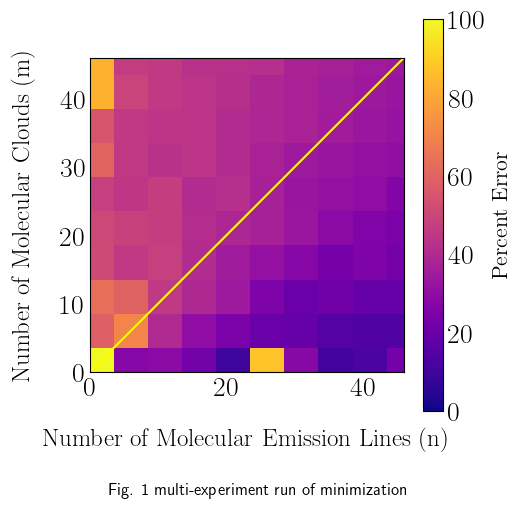

In [17]:
fig_num = plot_colormesh(m_n_array, 
                         summarized_data, 
                         "Percent Error Median", 
                         fig_num, 
                         description
                        )

In Fig. 1, the darker pixels represent instances of where $\vec{w}_{\mathrm{model}}$ is at a farther distance from $\vec{w}_{\mathrm{obs}}$, indicating a higher percent error in the model. There is significantly higher error in the upper triangle region. The predicted weights $\vec{w}_{\mathrm{model}}$ have a higher uncertainty where experiments have more molecular clouds ($m$) than emission lines ($n$). As originally predicted, our results are supported by the backbone for systems of linear equations: the system is unsolvable when there are fewer constraints than unknowns.

# Implementation Notes

While testing this minimization routine with a different optimization solver, we noticed an odd feature in the pcolormesh plot. A slope of significantly high error resides between our upper and lower triangle regions.

In [18]:
solver = 'BFGS'
bounds_constraint = False
penalty = False
iterate = 10
description = 'unconstrained run of minimization'
summarized_data, data  = run_multiple(m_n_array, 
                                      iterate, solver, 
                                      bounds_constraint, 
                                      penalty, 
                                      filename
                                     )

Progress: 100%|█████████████████████████████| 1000/1000 [00:45<00:00, 22.12it/s]


Time elapsed: 45.21 seconds


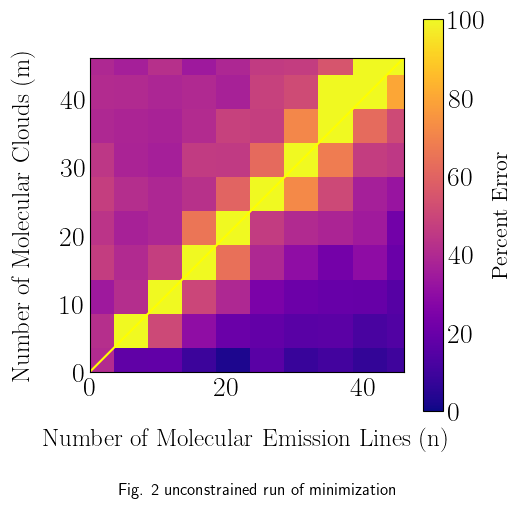

In [19]:
fig_num = plot_colormesh(m_n_array, 
                         summarized_data, 
                         "Percent Error Median", 
                         fig_num, 
                         description
                        )

Upon inspection of the `data` output below, we noticed negative weights in the `output_weights` column were being predicted by the minimization routine. This is an issue since a model galaxy with negative weights is unphysical.

In [20]:
data[110:120:30]

m,n,input_luminosities,input_weights,output_weights,F(l),Percent Error Mean,Percent Error Median,Percent Error Max
int64,int64,str17720,str830,str876,float64,float64,float64,float64
6,6,"{'data': array([[8.40065643e-01, 4.27654170e-01, 1.16879239e-01, 1.26541318e-01,\n 6.77206349e-01, 8.71224911e-01],\n [7.56305676e-01, 8.61840461e-01, 2.86054545e-01, 5.54413865e-01,\n 1.43245516e-01, 8.13826367e-01],\n [1.60366888e-02, 9.51069623e-01, 2.74598048e-01, 2.49672134e-01,\n 5.99660779e-01, 1.55181869e-02],\n [2.57308635e-01, 2.91432912e-01, 1.25301076e-01, 6.13135351e-01,\n 7.49262613e-01, 1.70393192e-01],\n [5.04293450e-01, 7.90128679e-01, 8.29741169e-04, 9.75918341e-01,\n 4.45608110e-01, 9.46387797e-01],\n [5.22760133e-01, 5.39992730e-01, 7.69244487e-01, 9.44516981e-01,\n 7.18878435e-01, 1.67709893e-01]])}","{'data': array([0.84215695, 0.73379703, 0.03399379, 0.83854725, 0.90267103,\n 0.17274516])}","{'data': array([0.85368238, 0.85056221, 0.23991849, 0.62926718, 0.79693263,\n 0.20858208])}",3.670158867765364e-10,113.4115829958186,18.329002720177602,605.7715285522087


One solution to this is to use a contrained solver and add a penalty term (Eq. $\ref{eq:penalty_eq}$) within the function we are minimizing (Eq. $\ref{eq:dist_eq}$)

In [21]:
solver = 'COBYLA'
bounds_constraint = False
penalty = True
description = 'penalty run of minimization'
summarized_data, data = run_multiple(m_n_array, 
                                     iterate, 
                                     solver, 
                                     bounds_constraint, 
                                     penalty, 
                                     filename
                                    )

Progress: 100%|█████████████████████████████| 1000/1000 [00:54<00:00, 18.46it/s]


Time elapsed: 54.17 seconds


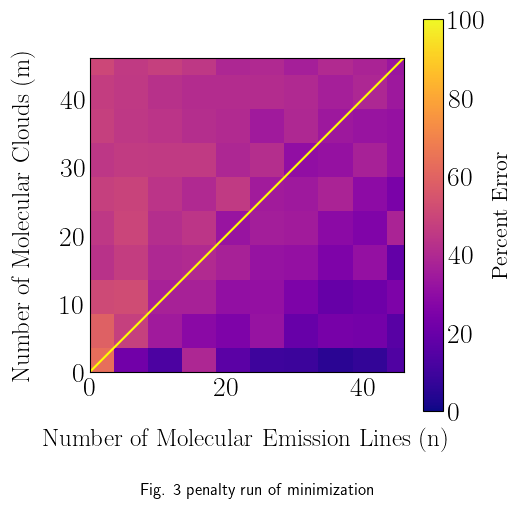

In [22]:
fig_num = plot_colormesh(m_n_array, 
                         summarized_data, 
                         "Percent Error Median", 
                         fig_num, 
                         description
                        )

Another solution is to use a constrained solver and adjust the bounds directly within the `scipy.optimize.minimize` function. 

In [23]:
bounds_constraint = True
penalty = False
description = 'bounds constraint run of minimization'
summarized_data, data  = run_multiple(m_n_array, 
                                      iterate, 
                                      solver, 
                                      bounds_constraint, 
                                      penalty, 
                                      filename
                                     )

Progress: 100%|█████████████████████████████| 1000/1000 [00:59<00:00, 16.78it/s]


Time elapsed: 59.59 seconds


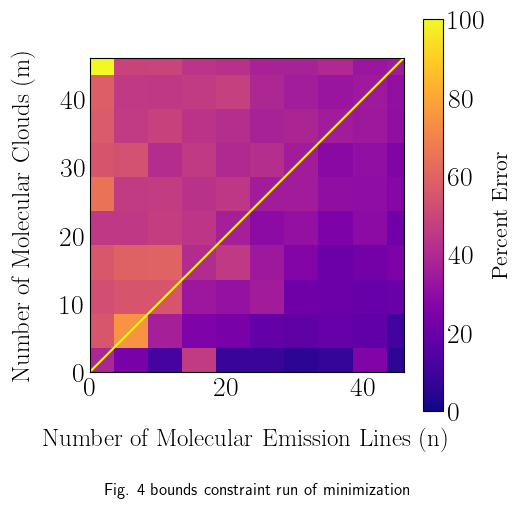

In [24]:
fig_num = plot_colormesh(m_n_array, 
                         summarized_data, 
                         "Percent Error Median", 
                         fig_num, 
                         description
                        )

Comparing these two solutions shown in Fig. 3 and Fig. 4, both are able to remove the unwanted negative weights. However, the bounds method is more desirable due to the penalty term having the potential to cause issues within the optimization function's derivative computations over Eq. $\ref{eq:dist_eq}$.